In [3]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from nn_robust_attacks.l2_attack import CarliniL2
from nn_robust_attacks.setup_mnist import MNIST, MNISTModel

Using TensorFlow backend.


In [4]:
sess = tf.Session(config=tf.ConfigProto())
K.set_session(sess)

data = MNIST()

class MNIST_Model:
    def __init__(self, session=None):
        self.num_channels = 1
        self.image_size = 28
        self.num_labels = 10

        model = Sequential()

        model.add(Conv2D(32, (3, 3),
                         input_shape=(28, 28, 1)))
        model.add(Activation('relu'))
        model.add(Conv2D(32, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Conv2D(64, (3, 3)))
        model.add(Activation('relu'))
        model.add(Conv2D(64, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(Flatten())
        model.add(Dense(200))
        model.add(Activation('relu'))
        model.add(Dense(200))
        model.add(Activation('relu'))
        model.add(Dense(10))

        self.model = model

    def predict(self, data):
        return self.model(data)

In [5]:
num_epochs = 5
batch_size = 128
train_temp = 1

training = False

In [6]:
from keras.models import load_model, Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten

def fn(correct, predicted):
    return tf.nn.softmax_cross_entropy_with_logits(labels=correct,
                                                   logits=predicted/train_temp)

# Train first model 
modelname = "models/trained_model1"
model1 = MNIST_Model()
if training:            
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model1.model.compile(loss=fn,
                  optimizer=sgd,
                  metrics=['accuracy'])
    model1.model.fit(data.train_data, data.train_labels,
              batch_size=batch_size,
              validation_data=(data.validation_data, data.validation_labels),
              nb_epoch=num_epochs,
              shuffle=True)
    
    model1.model.save(modelname)
    
else:
    model1.model = load_model(modelname, custom_objects={'fn':fn})
        
model1.model.summary()


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
activation_73 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
activation_74 (Activation)   (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 12, 12, 32)        0         
__________________________________________________________

In [7]:
# Train second model 
modelname = "models/trained_model2"
model2 = MNIST_Model()
if training:            
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model2.model.compile(loss=fn,
                  optimizer=sgd,
                  metrics=['accuracy'])
    model2.model.fit(data.train_data, data.train_labels,
              batch_size=batch_size,
              validation_data=(data.validation_data, data.validation_labels),
              nb_epoch=num_epochs,
              shuffle=True)
    
    model2.model.save(modelname)
    
else:
    model2.model = load_model(modelname, custom_objects={'fn':fn})
    
model2.model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
activation_79 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
activation_80 (Activation)   (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 10, 10, 64)        18496     
_________________________________________________________________
activation_81 (Activation)   (None, 10, 10, 64)      

In [8]:
# Performance of first model
from keras.datasets import mnist as data_keras
from keras.utils import to_categorical

(x_train, y_train), (x_test, y_test) = data_keras.load_data()
x_train = x_train[...,np.newaxis] /255.0
x_test = x_test[...,np.newaxis] / 255.0
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

scores = model1.model.evaluate(x_test, y_test)
print("loss={}, accuracy={}".format(*scores))

10000/10000 [==============================] - 2s 172us/step
loss=0.24138298129886387, accuracy=0.9215999841690063


In [9]:
# Performance of second model
scores = model2.model.evaluate(x_test, y_test)
print("loss={}, accuracy={}".format(*scores))

10000/10000 [==============================] - 2s 165us/step
loss=0.13339069919716567, accuracy=0.9563000202178955


In [10]:
def generate_data(data, samples, targeted=True, start=0, inception=False):
    """
    Generate the input data to the attack algorithm.
    data: the images to attack
    samples: number of samples to use
    targeted: if true, construct targeted attacks, otherwise untargeted attacks
    start: offset into data to use
    inception: if targeted and inception, randomly sample 100 targets intead of 1000
    """
    inputs = []
    targets = []
    for i in range(samples):
        if targeted:
            if inception:
                seq = random.sample(range(1,1001), 10)
            else:
                #seq = range(data.test_labels.shape[1])
                seq = range(1)

            for j in seq:
                if (j == np.argmax(data.test_labels[start+i])) and (inception == False):
                    continue
                inputs.append(data.test_data[start+i])
                targets.append(np.eye(data.test_labels.shape[1])[j])
        else:
            inputs.append(data.test_data[start+i])
            targets.append(data.test_labels[start+i])

    inputs = np.array(inputs)
    targets = np.array(targets)

    return inputs, targets


inputs, targets = generate_data(data, 
                                samples=1, 
                                targeted=True, 
                                start=0, 
                                inception=False)

In [125]:
test_size = 250
each_num = test_size / 10
trial_data = []
indicies = []

for i in range(0, 10):
    trial_data.append([])
    indicies.append([])
    for idx, img in enumerate(data.test_data):
        if np.nonzero(data.test_labels[idx])[0][0] == i:
            trial_data[i].append(data.test_data[idx])
            indicies[i].append(idx)
        if len(trial_data[i]) >= each_num:
            break

In [126]:
import random
target_data = []

for i in range(0, 10):
    target_data.append([])
    for j in range(0, int(each_num)):
        numbers = list(range(0, i)) + list(range(i + 1, 10))
        r = random.choice(numbers)
        target_data[i].append(r)

In [127]:
target_labels = []
for i in range(0, 10):
    target_labels.append(to_categorical(target_data[i]))

In [138]:
def get_label_confidence(image, model):
    pr = model.predict(image)
    print(pr)
    image_class = model.predict_classes(image)
    return 'Predicted {} : {:.7f}'.format(image_class[0], max(max(pr)))

In [129]:
inp = inputs[0][:, :, 0]
plt.set_cmap('Greys_r')
plt.figure()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [131]:
print('Target', np.where(targets[0]==1)[0][0])
print('Model 1', get_label_confidence(inputs[0][np.newaxis, ...], model1.model))
print('Model 2', get_label_confidence(inputs[0][np.newaxis, ...], model2.model))

Target 4
Model 1 Predicted 0 : 12.4054279
Model 2 Predicted 0 : 15.4724684


In [132]:
true_label = 0
inputs = np.asarray(trial_data[true_label])
targets = target_labels[true_label]

adv = CarliniL2(sess, model1, model2=model2).attack(inputs, targets)

go up to 25
tick 0
[10000000000.0]
0 (0.012016143, 0.009805337, 0.0010156848, 0.0011951214)
1000 (0.011059336, 0.009835793, 3.5088765e-06, 0.0012200349)
2000 (0.011060073, 0.009835217, 4.602964e-06, 0.001220253)
[10000000000.0]
0 (0.11103164, 0.09805006, 0.0010321221, 0.0119494535)
1000 (0.110187724, 0.098026656, 0.00044113357, 0.011719936)
2000 (0.110178985, 0.09801134, 0.00045044083, 0.011717209)
[10000000000.0]
0 (1.1010325, 0.98048097, 0.0010398421, 0.11951168)
1000 (1.0654922, 0.94527704, 0.036316052, 0.08389903)
2000 (1.0654202, 0.9452715, 0.03641908, 0.08372952)
[10000000000.0]
0 (11.000973, 9.804761, 0.0010425046, 1.1951694)
1000 (5.206903, 0.011818886, 5.179566, 0.015518295)
2000 (5.2064686, 0.0918417, 5.114627, 0.0)
3000 (5.2075186, 0.06428003, 5.1432385, 0.0)
[5.181034]
0 (6.0510025, 5.39262, 0.0010422142, 0.6573401)
1000 (4.731071, 3.2548373, 1.4762338, 0.0)
2000 (4.731423, 3.2401888, 1.4699683, 0.02126534)
[5.181034]
0 (8.525986, 7.5986886, 0.0010423984, 0.92625433)
1000 (

In [133]:
from numpy import savetxt

np.save('inputs_' + str(true_label) + '.csv', inputs)
np.save('adv_' + str(true_label) + '.csv', adv)

Valid:


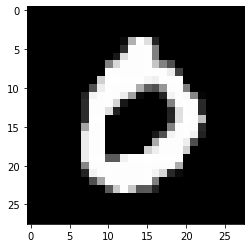

In [134]:
print("Valid:")
plt.imshow(inputs[0][:,:,0])

Adversarial:


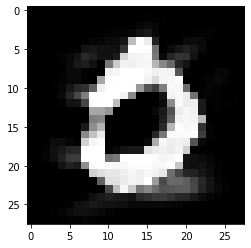

In [135]:
print("Adversarial:")
plt.imshow(adv[0][:,:,0])

In [136]:
adv[0].shape

(28, 28, 1)

In [19]:
def get_label_confidence(image, model):
    pr = model.predict(image)
    pr = np.array([np.exp(x) for x in pr])
    pr = pr / np.sum(pr)
    image_class = model.predict_classes(image)
    return 'Predicted {} : {:.7f}'.format(image_class[0], max(max(pr)))

In [20]:
adv = np.load('adv_0.csv.npy')

for i in range(0, 25):
    print(i)
    print('Model 1', get_label_confidence(adv[i][np.newaxis, ...], model1.model))
    print('Model 2', get_label_confidence(adv[i][np.newaxis, ...], model2.model))

0
Model 1 Predicted 9 : 0.4678299
Model 2 Predicted 0 : 0.9800469
1
Model 1 Predicted 5 : 0.4686376
Model 2 Predicted 0 : 0.9995435
2
Model 1 Predicted 9 : 0.4944022
Model 2 Predicted 0 : 0.9997508
3
Model 1 Predicted 7 : 0.3662135
Model 2 Predicted 0 : 0.9994199
4
Model 1 Predicted 4 : 0.1831267
Model 2 Predicted 0 : 0.9583766
5
Model 1 Predicted 5 : 0.3514885
Model 2 Predicted 0 : 0.9979216
6
Model 1 Predicted 1 : 0.2921824
Model 2 Predicted 0 : 0.9999867
7
Model 1 Predicted 6 : 0.4545483
Model 2 Predicted 0 : 0.9999560
8
Model 1 Predicted 7 : 0.4311803
Model 2 Predicted 0 : 0.9996916
9
Model 1 Predicted 8 : 0.1661454
Model 2 Predicted 0 : 0.9916505
10
Model 1 Predicted 7 : 0.3357463
Model 2 Predicted 0 : 0.9891955
11
Model 1 Predicted 1 : 0.2835408
Model 2 Predicted 0 : 0.8916319
12
Model 1 Predicted 9 : 0.4766327
Model 2 Predicted 0 : 0.9993359
13
Model 1 Predicted 8 : 0.2657042
Model 2 Predicted 0 : 0.9998193
14
Model 1 Predicted 5 : 0.4781470
Model 2 Predicted 0 : 0.9999985
15
Mo